### Things to get from data
1. time tkane for introduction trial ([4,2,3,5,1])
2. time taken for each imitation trial
3. initial states, sequence of comparison, final state for each test trial
4. choices for demo trials
5. initial states, sequence of comparison, final state for each demo trial
6. description

In [1]:
import pandas as pd
import numpy as np
import copy
import glob 
import os 
import csv
import matplotlib.pyplot as plt
import json

In [2]:
#calculates sequence of comparisons, whether they swap and number of least necessary comparisons for an array with a certain order (for example: 6 4 3 1 5 2)
#_f means forward and _b means backward
def imit_seq(array):
    aa=copy.copy(array)
    comp_seq=[]
    swap_or_not=[]
    ii_f=0
    nn=0
    while nn<30:
        
        if aa[ii_f]<aa[ii_f+1]: #correct ofer and keep going forward
            comp_seq.append([ii_f,ii_f+1])
            swap_or_not.append(0)
            nn+=1
            ii_f+=1
        else: #switch when going forward
            comp_seq.append([ii_f,ii_f+1])
            aa[ii_f],aa[ii_f+1]=aa[ii_f+1],aa[ii_f]
            swap_or_not.append(1)
            nn+=1

            ii_b=ii_f
            ii_f+=1

            while nn<30:
                if ii_b==0: #back to position zero
                    break
                if aa[ii_b-1]>aa[ii_b]: #switch and keep going back
                    comp_seq.append([ii_b-1,ii_b])
                    swap_or_not.append(1)
                    aa[ii_b-1],aa[ii_b]=aa[ii_b],aa[ii_b-1]
                    nn+=1
                    ii_b-=1
                if aa[ii_b-1]<aa[ii_b]: #stop going back
                    if ii_b==0:
                        break
                    else:
                        comp_seq.append([ii_b-1,ii_b])
                        swap_or_not.append(0)
                        nn+=1
                        break
        if (aa==np.array(range(1, len(array)+1, 1))).all():
            if np.array([len(array)-2,len(array)-1]) in np.array(comp_seq):
                break
    return array,nn,comp_seq,swap_or_not




# #verify n_nece_compare
# arr_test=np.array([6,4,3,1,5,2]) #13
# arr_test=np.array([1, 2, 3, 4, 8, 7, 6, 5])
# # arr_test=np.array([2,1,4,3,6,5]) #7
# # arr_test=np.array([4,6,3,2,5,1]) #13

# print(imit_seq(arr_test))

In [3]:
path_up='C:/Users/guoqi/GITHUB_QGUO/Gold_Block_Data_Analysis/Data/Pilot/'

In [4]:
# generate a file with prolific id from the demographic file
# for example pid_from_demographic('Cohort2_Pilot1_Demographic.csv','pid_Cohort2_Pilot.csv')
# demo_file:demographic file "xxx.csv"
# pid file "xxx.csv"
def pid_from_demographic(demo_file,pid_file): 
    
    path='C:/Users/guoqi/GITHUB_QGUO/Gold_Block_Data_Analysis/Data/Pilot/'
    
    demographic_data = pd.read_csv(os.path.join(path,demo_file)) 
    pid=demographic_data[demographic_data['Status'] == 'AWAITING REVIEW']
    pid=pid['Participant id'].to_list()
    # print(pid)
    with open(os.path.join(path,pid_file), 'w',newline='') as csvfile:
        # print(os.path.join(path,pid_file))
        # print(csvfile)
        writer = csv.writer(csvfile)
        writer.writerows([pid])
    return pid


In [5]:
# Pair prolific ID with run_id to find Cognition.run datafiles corresponding to prolific ID
def ids(pid_list,data_path,col_check):
    #pid_list is all pid from demographic file with "awaiting review"
    #dat_path is the path for data files
    #col_check is the columns to be checked ('PROLIFIC ID' for example)
    
    pid_whole_cohort=[str(ii) for ii in pid_list]
    # print(pid_whole_cohort)
    
    csv_files = glob.glob(os.path.join(data_path, '*.csv')) 
    run_id_cohort=[]
    p_id_cohort=[]
    p_id_last4=[]
    for csv in csv_files:
        data = pd.read_csv(csv) 
        if not all(col in data.columns for col in col_check):
            continue
        else:
            data_useful=data[['run_id','PROLIFIC_PID']]
            pid_cache=data_useful['PROLIFIC_PID'][0]
            # pid_4=pid_cache[-4:] #last four digit of prolific id
            if pid_cache in pid_whole_cohort:
                run_id_cohort.append(data_useful['run_id'][0])
                p_id_cohort.append(pid_cache)
                p_id_last4.append(pid_cache[-4:])
    ids_df = pd.DataFrame(
    {'run_id': run_id_cohort,
     'pid': p_id_cohort,
     'pid_last4': p_id_last4
    })
    return ids_df

In [13]:
def score(run_id,n_test,data_path,quantile):
        data=pd.read_csv(data_path+str(run_id)+'.csv')
        data_useful=data[['trial_type','time_elapsed', 'run_id','PROLIFIC_PID','STUDY_ID','stimulus','response','phase','question_order']]
            
        p_gnome_all=[]
        for ii in range(0,n_test):
            indices_test=data_useful[data_useful['phase'] == "Test "+str(ii)].index.to_numpy()
            # print(indices_test)

            # get final order in test trials of participants
            fin_order_test=data_useful['phase'][max(indices_test)+1]
            fin_order_test=fin_order_test[13:].split(",")
            fin_order_test=[int(x) for x in fin_order_test]==[1,2,3,4,5] or [int(x) for x in fin_order_test]==[1,2,3,4,5,6,7,8] #true for correct sorting

        
            # get initial order in test trials
            ini_order_test=data_useful['phase'][min(indices_test)-1]
            ini_order_test=ini_order_test[15:].split(",")
            ini_order_test=[int(x)+1 for x in ini_order_test]
            
        
            comp_test = [data['response'][i] for i in indices_test]
            comp_test=[int(x) for x in comp_test]
            comp_test=comp_test[:-1]
            if len(comp_test)%2==1:
                comp_test=comp_test[:-1]
            n_comp_ptcp=int(len(comp_test)/2) #number of comparison made by participants
            comp_test=np.reshape(comp_test, (n_comp_ptcp, 2)).tolist()
            

            for row in comp_test:
                if row[0]==row[1]:
                    comp_test.remove(row)
            for row in comp_test:
                if row[0]>row[1]:
                    cache=row[0]
                    row[0]=row[1]
                    row[1]=cache
            # print(comp_test)

        
            #Sliding windows
            windows_test={}
            for jj in range(len(comp_test),1,-1):
                for kk in range(0,len(comp_test)-jj+1):
                    if jj not in windows_test.keys():
                        windows_test[jj]=[comp_test[kk:(kk+jj)]]
                    else:
                        windows_test[jj].append(comp_test[kk:(kk+jj)])
            
            array_cache,nn_cache,comp_seq_true,swap_or_not_cache=imit_seq(np.array(ini_order_test))
            # print(comp_seq_true)
            
            windows_true={}
            for jj in range(len(comp_seq_true),1,-1):
                for kk in range(0,len(comp_seq_true)-jj+1):
                    if jj not in windows_true.keys():
                        windows_true[jj]=[comp_seq_true[kk:(kk+jj)]]
                    else:
                        windows_true[jj].append(comp_seq_true[kk:(kk+jj)])
        
            common_size=min(len(comp_seq_true),len(comp_test))
            n_comp_true=len(comp_seq_true) #number of comparison for correct gnome
            sim={}
            for mm in range(2,n_comp_true+1):
                sim[mm]=0
                if mm<=common_size:
                    win_test=windows_test[mm]
                    win_true=windows_true[mm]
                    for comp_test in win_test:
                        if comp_test in win_true:
                            sim[mm]+=1
                else:
                    sim[mm]=0
            # print(sim)

        
            sum_test=0
            sum_true=0
            for key in sim.keys():
                sum_true+=key*(len(comp_seq_true)-key)
                # sum_true+=key
                if sim[key]>0:
                    # sum_test+=key*sim[key]/len(windows_true[key])
                    sum_test+=key*sim[key]
            if sum_test>sum_true:
                sum_test=sum_true    
            # print(sum_test)
            # print(sum_true)

            p_gnome=sum_test/sum_true
            p_gnome_all.append(p_gnome)

        p_quantile_criteria=np.quantile(p_gnome_all, quantile)
        
        p_quantile=[p for p in p_gnome_all if p>=p_quantile_criteria]
        p_quantile_mean=np.average(p_quantile)
        # print('checkmark',p_quantile_mean)

        return p_quantile_mean

n_test=10
quantile=0.5
run_id=52
path_cohort1='C:/Users/guoqi/GITHUB_QGUO/Gold_Block_Data_Analysis/Data/Pilot/Cohort1_30Participants_Jan31/'
aa=score(run_id,n_test,path_cohort1,quantile)
print(aa)

0.8335518648018647


### Cohort 1

In [14]:
pid_cohort1_total=pid_from_demographic('Cohort1_30Participants_Demographic.csv','pid_Cohort1.csv')
path_cohort1='C:/Users/guoqi/GITHUB_QGUO/Gold_Block_Data_Analysis/Data/Pilot/Cohort1_30Participants_Jan31/'
ids_cohort1=ids(pid_cohort1_total,path_cohort1,['PROLIFIC_PID','phase'])
run_id_cohort1=ids_cohort1['run_id']
run_id_cohort1_list=run_id_cohort1.values.tolist()
n_test=10

In [15]:
# Calculate score of how well participants learn gnome sort
performance_cohort=[]
performance_list=[]
p_half_mean_list=[]
curriculum_all=[]
curriculum_n_item=[]
curriculum_ooo=[]


# print(run_id_cohort1)
Cohort1_all=pd.DataFrame(columns=['run_id','performance','performance_best5'])
Cohort1_everyother=pd.DataFrame(columns=['run_id','performance'])
for pp in run_id_cohort1_list:
    data=pd.read_csv(path_cohort1+str(pp)+'.csv')
    data_useful=data[['trial_type','time_elapsed', 'run_id','PROLIFIC_PID','STUDY_ID','stimulus','response','phase','question_order']]

    index_crclm=data_useful[data_useful['trial_type'] == "survey-multi-choice"].index.to_numpy()
    crclm=data_useful['response'][index_crclm]
    # print(crclm.values)
    json_str = crclm.values[0]
    data = json.loads(json_str)

    result = []
    n_item=[]
    OOO=[]
    # 
    for i in range(0, len(data), 2): 
        item_key = f'Q{i}'
        rating_key = f'Q{i+1}'
        
        # Get the number from "X-item" format
        item_num = data[item_key].split('-')[0]
        rating = data[rating_key]

        # item_oor = data[item_key].split('-')[1] #out of order
        # rating = data[rating_key]
        
        # Combine them in the desired format
        result.append(f'{item_num}-{rating}')
        n_item.append(item_num)
        OOO.append(rating)

    # curriculum_all.append(n_item)
    curriculum_n_item.append(n_item)
    curriculum_ooo.append(OOO)

    quantile=0
    performance=score(pp,n_test,path_cohort1,quantile)
    performance_best5=score(pp,n_test,path_cohort1,0.5)
    Cohort1_all.loc[len(Cohort1_all)] = [pp,performance,performance_best5]
    performance_list.append(performance)
    # performance_cohort.append([pp,performance])

# print(curriculum_all)
# Cohort1_all['Curriculum']=curriculum_all
Cohort1_all['Curriculum_n_item']=curriculum_n_item
Cohort1_all['Curriculum_OOO']=curriculum_ooo

Cohort1_all = Cohort1_all.sort_values(by='performance',ascending=False)
#swtich 72 and 63 because this is how it was the basis for the notes cohort2 saw, both 72 and 63 perfectly learned gnome sort (average p=1)
row1 = Cohort1_all.index[Cohort1_all['run_id'] == 72.0].tolist()[0]
row2 = Cohort1_all.index[Cohort1_all['run_id'] == 63.0].tolist()[0]
temp = Cohort1_all.loc[row1].copy()
Cohort1_all.loc[row1] = Cohort1_all.loc[row2].copy()
Cohort1_all.loc[row2] = temp
print(Cohort1_all)
# Cohort1_all.plot(x="performance", y=["performance_best5"],
#         kind="scatter", figsize=(10, 10))

run_id_c1_sorted_all_list=Cohort1_all['run_id'].values.tolist()
run_id_c1_sorted_all_list=[int(x) for x in run_id_c1_sorted_all_list]
Cohort1_everyother=Cohort1_all[::2]

# Cohort1_everyother = Cohort1_all.iloc[[0, 1, 3, 5, 7,]]
run_id_c1_sorted_evoth_list=Cohort1_everyother['run_id'].values.tolist()
run_id_c1_sorted_evoth_list=[int(x) for x in run_id_c1_sorted_evoth_list]
# print(run_id_c1_sorted_evoth_list)

# plt.hist(performance_list, bins=20, color='skyblue', edgecolor='black')
# plt.xlabel('Performance')
# plt.ylabel('Frequency')
   
# print(Cohort1_everyother)
Cohort1_all.to_csv(os.path.join(path_up,'Cohort1_all.csv'))
Cohort1_everyother.to_csv(os.path.join(path_up,'Cohort1_everyother.csv'))


# crclm=crclm.split(",")

# score(44,10,path_cohort1,0)

    run_id  performance  performance_best5   Curriculum_n_item  \
12    55.0     1.000000           1.000000  [5, 8, 5, 8, 5, 8]   
26    63.0     1.000000           1.000000  [5, 8, 5, 5, 8, 8]   
18    72.0     1.000000           1.000000  [5, 5, 5, 5, 8, 8]   
13    56.0     0.942081           1.000000  [5, 8, 5, 8, 5, 8]   
8     44.0     0.928959           1.000000  [5, 5, 5, 8, 8, 5]   
5     37.0     0.905773           1.000000  [5, 8, 5, 5, 8, 8]   
20    66.0     0.888285           1.000000  [5, 8, 5, 5, 8, 8]   
3     35.0     0.859265           1.000000  [5, 8, 5, 5, 8, 8]   
16    60.0     0.847537           1.000000  [5, 5, 5, 5, 5, 5]   
28    75.0     0.622118           1.000000  [5, 8, 5, 8, 5, 8]   
10    52.0     0.533691           0.833552  [5, 5, 5, 8, 8, 8]   
0     30.0     0.503541           0.780500  [5, 8, 8, 8, 8, 8]   
29    76.0     0.457299           0.708104  [5, 8, 5, 8, 5, 5]   
17    62.0     0.429623           0.740314  [5, 8, 5, 5, 8, 8]   
7     43.0

In [16]:
Cohort1_all = Cohort1_all.sort_values(by='performance',ascending=False)
print(Cohort1_all)
row1 = Cohort1_all.index[Cohort1_all['run_id'] == 72.0].tolist()[0]
# print(row1)
row2 = Cohort1_all.index[Cohort1_all['run_id'] == 63.0].tolist()[0]
Cohort1_all.iloc[18], Cohort1_all.iloc[26] = Cohort1_all.iloc[26].copy(), Cohort1_all.iloc[18].copy()
print(Cohort1_all)

    run_id  performance  performance_best5   Curriculum_n_item  \
12    55.0     1.000000           1.000000  [5, 8, 5, 8, 5, 8]   
26    63.0     1.000000           1.000000  [5, 8, 5, 5, 8, 8]   
18    72.0     1.000000           1.000000  [5, 5, 5, 5, 8, 8]   
13    56.0     0.942081           1.000000  [5, 8, 5, 8, 5, 8]   
8     44.0     0.928959           1.000000  [5, 5, 5, 8, 8, 5]   
5     37.0     0.905773           1.000000  [5, 8, 5, 5, 8, 8]   
20    66.0     0.888285           1.000000  [5, 8, 5, 5, 8, 8]   
3     35.0     0.859265           1.000000  [5, 8, 5, 5, 8, 8]   
16    60.0     0.847537           1.000000  [5, 5, 5, 5, 5, 5]   
28    75.0     0.622118           1.000000  [5, 8, 5, 8, 5, 8]   
10    52.0     0.533691           0.833552  [5, 5, 5, 8, 8, 8]   
0     30.0     0.503541           0.780500  [5, 8, 8, 8, 8, 8]   
29    76.0     0.457299           0.708104  [5, 8, 5, 8, 5, 5]   
17    62.0     0.429623           0.740314  [5, 8, 5, 5, 8, 8]   
7     43.0

In [17]:
ii=0
ling_all_cohort1=[]
run_id_sorted=[]
for run_id in run_id_c1_sorted_all_list:
    
    data=pd.read_csv(path_cohort1+str(run_id)+'.csv')
    data_useful=data[['trial_type','time_elapsed', 'run_id','PROLIFIC_PID','STUDY_ID','stimulus','response','phase','question_order']]
    index_ling=data_useful[data_useful['trial_type'] == "survey-text"].index.to_numpy()
    ling=str(list(data_useful['response'][index_ling]))
    ling=ling[9:-4]
    ling=ling.replace("\\\\n", "<br>") 
    ling=ling.replace("\\", "")
    ling_all_cohort1.append(ling)
    run_id_sorted.append(run_id)

    if ii==0:
        initial_data = {'run_id': [run_id], 
                'Notes': [ling]}
        ling_df_all = pd.DataFrame(initial_data, columns = ['run_id', 'Notes'])
    else:
        ling_df_all.loc[len(ling_df_all)] = [run_id, ling]

    ii+=1

print(ling_df_all)
# ling_id_df.to_csv(os.path.join(path_up,'Note_cohort1.csv'))


ii=0
ling_all_cohort1=[]
run_id_sorted=[]
for run_id in run_id_c1_sorted_evoth_list:
    
    data=pd.read_csv(path_cohort1+str(run_id)+'.csv')
    data_useful=data[['trial_type','time_elapsed', 'run_id','PROLIFIC_PID','STUDY_ID','stimulus','response','phase','question_order']]
    index_ling=data_useful[data_useful['trial_type'] == "survey-text"].index.to_numpy()
    ling=str(list(data_useful['response'][index_ling]))
    ling=ling[9:-4]
    ling=ling.replace("\\\\n", "<br>") 
    ling=ling.replace("\\", "")
    ling_all_cohort1.append(ling)
    run_id_sorted.append(run_id)

    if ii==0:
        initial_data = {'run_id': [run_id], 
                'Notes': [ling]}
        ling_df_everyother = pd.DataFrame(initial_data, columns = ['run_id', 'Notes'])
    else:
        ling_df_everyother.loc[len(ling_df_everyother)] = [run_id, ling]

    ii+=1

print(ling_df_everyother)
# ling_id_df.to_csv(os.path.join(path_up,'Note_cohort1.csv'))


    run_id                                              Notes
0       55  Check if it is moving left to right. They chec...
1       63  KEYS TO OMGNE SORT<br>If a pair changes places...
2       72  Step 1: Designate the leftmost object as Objec...
3       56  Starting with the left-most block, click on th...
4       44  Start by comparing the first two blocks. Then ...
5       37  COMPARE TWO ITEMS UNTIL THEY STOP ROTATING, ON...
6       66  Continue to swap pieces until you have put the...
7       35  as you sort the gold blocks, compare them to t...
8       60  Click on the blocks in pairs from left to righ...
9       75  Select 2 blocks. It is recommended to start pl...
10      52  Instead of using a compare the first block to ...
11      30             check on patterns and learn to do them
12      76  Start left from right and if there is a change...
13      62  Select items starting at the left and then to ...
14      43  Start with the first block and move it to the ...
15      

In [18]:
#every other notes
# ling_id_df_half=ling_id_df.iloc[::2, :]
# ling_id_df_half=ling_id_df
# ling_id_df_half.to_csv(os.path.join(path_up,'Note_cohort1_half.csv'))
# ling_id_df_half=ling_id_df_half.groupby(ling_id_df_half.index // 2).first()
# ling_id_df_half=ling_id_df_half[['Notes']]
ling_all_list=ling_df_all['Notes'].tolist()
ling_everyother_list=ling_df_everyother['Notes'].tolist()
# ling_id_df_half.index/22
# print(len(ling_all_list))
# print(len(ling_everyother_list))

Cohort1_all['Notes'] = ling_all_list
Cohort1_all.to_csv(os.path.join(path_up,'Cohort1_all.csv'))

Cohort1_everyother['Notes'] = ling_everyother_list
Cohort1_everyother.to_csv(os.path.join(path_up,'Cohort1_everyother.csv'))
# ling_id_df_half

### Analayzing experiments with note rating

In [19]:
#Get legit run_id and pid
pid_cohort2_total=pid_from_demographic('Cohort2_Demographic.csv','pid_Cohort2.csv')
path_cohort2='C:/Users/guoqi/GITHUB_QGUO/Gold_Block_Data_Analysis/Data/Pilot/Cohort2_30Participants/'
ids_cohort2=ids(pid_cohort2_total,path_cohort2,['PROLIFIC_PID','phase','presented_choices'])
run_id_cohort2=ids_cohort2['run_id']
run_id_cohort2_list=run_id_cohort2.values.tolist()
n_test=6
# print(ids_cohort2)

    run_id  performance
16    31.0     1.000000
6     17.0     1.000000
8     19.0     1.000000
10    22.0     1.000000
11    23.0     1.000000
14    29.0     0.952169
5     16.0     0.840812
1     12.0     0.798731
13    28.0     0.786492
22    41.0     0.759179
2     13.0     0.682692
12    26.0     0.622149
0     11.0     0.616173
26    45.0     0.525715
21    40.0     0.476655
19    36.0     0.474135
4     15.0     0.441624
3     14.0     0.337132
18    33.0     0.266227
28     9.0     0.237020
20    38.0     0.230552
25    44.0     0.210880
27    46.0     0.166286
15    30.0     0.054819
9     20.0     0.040429
24    43.0     0.039044
23    42.0     0.019571
7     18.0     0.011111
17    32.0     0.003326
    run_id  performance
16    31.0     1.000000
8     19.0     1.000000
11    23.0     1.000000
5     16.0     0.840812
13    28.0     0.786492
2     13.0     0.682692
0     11.0     0.616173
21    40.0     0.476655
4     15.0     0.441624
18    33.0     0.266227
20    38.0     0

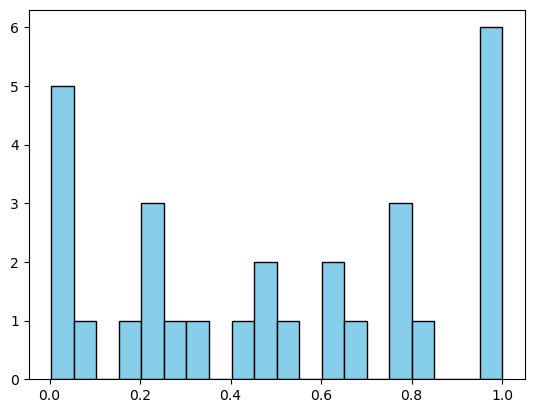

In [20]:
# Calculate score of how well participants learn gnome sort
performance_cohort2=[]
performance1_list=[]

Cohort2_all=pd.DataFrame(columns=['run_id','performance'])
Cohort2_everyother=pd.DataFrame(columns=['run_id','performance'])
for pp in run_id_cohort2_list:
    data=pd.read_csv(path_cohort2+str(pp)+'.csv')
    data_useful=data[['trial_type','time_elapsed', 'run_id','PROLIFIC_PID','STUDY_ID','stimulus','response','phase','question_order']]
        
    quantile=0
    n_test=6
    # print(pp)
    performance=score(pp,n_test,path_cohort2,quantile)
    Cohort2_all.loc[len(Cohort2_all)] = [pp,performance]
    performance1_list.append(performance)
    performance_cohort2.append([pp,performance])
    
Cohort2_all = Cohort2_all.sort_values(by='performance',ascending=False)
print(Cohort2_all)
Cohort2_everyother=Cohort2_all[::2]

plt.hist(performance1_list, bins=20, color='skyblue', edgecolor='black')
   
print(Cohort2_everyother)
Cohort2_all.to_csv(os.path.join(path_up,'Cohort2_all.csv'))
Cohort2_everyother.to_csv(os.path.join(path_up,'Cohort2_everyother.csv'))

In [21]:
#Preprocess for Bradley-Terry Model

matrix_rating_total=np.zeros((15,15))
for run_id in run_id_cohort2_list:
    matrix_rating=np.zeros((15,15))
    # print("run_id is",run_id)
    # data = pd.read_csv(csv) 
    data=pd.read_csv(path_cohort2+str(run_id)+'.csv')
    data_useful=data[['trial_type','time_elapsed', 'run_id','PROLIFIC_PID','STUDY_ID','stimulus','response','phase','presented_choices']]
    # print(data_useful)
    

    for ii in range(0,14):
        indices_rating=data_useful[data_useful['phase'] == "Note Comparison"].index.to_numpy()
        if ii==5 and data_useful['response'][min(indices_rating)+(ii*2)+1]==1:
            print(run_id,"Did not pass attention check")
        if ii==9 and data_useful['response'][min(indices_rating)+(ii*2)+1]==0:    
            print(run_id,"Did not pass attention check")

        if ii!=5 and ii!=9:
            # print(indices_rating)
            index_choices=min(indices_rating)+(ii*2)
            index_betterone=index_choices+1
            # print(index_choices)
            # print(index_betterone)
            choices=data_useful['presented_choices'][min(indices_rating)+(ii*2)].split('","')
            # print(len(choices))
            choices = [s.replace('["', '') for s in choices]  
            choices = [s.replace('"]', '') for s in choices]  
            choices = [s.replace('\\', '') for s in choices]  

            indices_two_notes=[]
            for choice in choices:
                # print(choice)
                index_note=ling_everyother_list.index(choice)
                # pos1 = Cohort1_all[Cohort1_all['Notes'] == choice].index[0]
                # print(index_note)
                # ling_id_df_half.tolist()
                indices_two_notes.append(index_note)
                run_id_note=run_id_sorted[index_note]
                # run_id_note=Cohort1_all.loc[pos1,'run_id']


                # print(index_note)
                # print("length")
                # print(min(indices_rating)+(ii*2)+1)
                # print(len(data_useful))
            if (min(indices_rating)+(ii*2)+2)>len(data_useful):
                print('Rating Skipped')
            else:
                # print("indices",indices_two_notes)
                better_one=data_useful['response'][min(indices_rating)+(ii*2)+1]
                a=indices_two_notes[0]
                b=indices_two_notes[1]
                if better_one==0:
                    matrix_rating[a][b]+=1
                else:
                    matrix_rating[b][a]+=1
    matrix_rating_total=matrix_rating_total+matrix_rating
print(matrix_rating_total)
# sum(matrix_rating_total)
print(np.matrix(matrix_rating_total).sum())

ValueError: 'go from left to right selecting 2 at a time.' is not in list

In [ ]:
#Validating Bradley-Terry model based on worked example on wikipedia
matrix_example=[[0,2,0,1],[3,0,5,0],[0,3,0,1],[4,0,3,0]]
matrix_example_df=pd.DataFrame(matrix_example)

def BT(matrix_win_lose):
    p_list_converge=[]
    p_list=np.ones(len(matrix_win_lose))
    for jj in range(100):
        multi_all=1
        for ii in range(len(p_list)):
            wij=matrix_win_lose.iloc[ii]
            wji=matrix_win_lose[ii]
            pij_nom=p_list/(p_list[ii]+p_list)
            pij_den=1/(p_list[ii]+p_list)
            p_list[ii]=sum(wij*pij_nom)/sum(wji*pij_den)
            multi_all*=p_list[ii]
        geo_mean=multi_all**(1/len(p_list))
        p_list=p_list/geo_mean
        p_list_converge.append(p_list)
        if jj>0 and abs(sum(p_list_converge[jj])-sum(p_list_converge[jj-1]))<0.00001:
            break
    return p_list
# print(p_list_converge)
print(BT(matrix_example_df))
# print(geo_mean)

[0.63983316 1.04331568 0.65981147 2.27037535]


In [ ]:
ranking_BT_everyother=BT(pd.DataFrame(matrix_rating_total))
print(BT(pd.DataFrame(matrix_rating_total)))
Cohort1_everyother['Note rating'] = ranking_BT_everyother

Cohort1_everyother.to_csv(os.path.join(path_up,'Cohort1_everyother.csv'))

[0.6214567  1.74906992 0.92456393 1.75471508 1.43005868 1.07654789
 1.0520941  1.44617014 1.06302724 0.54954727 0.9392574  0.56717607
 0.91677382 0.91591667 0.92641819]


C:\Users\guoqi\AppData\Local\Temp\ipykernel_24836\237993971.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cohort1_everyother['Note rating'] = ranking_BT_everyother
